In [1]:
import os
import os.path as osp
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imsave, imread
from skimage import img_as_ubyte, img_as_float
import sys
import monai

%load_ext autoreload
%autoreload 2

In [2]:
def imshow_pair(im, gdt, vmin1=None, vmax1=None, vmin2=None, vmax2=None):
    f, ax = plt.subplots(1, 2, figsize=(10,5))
    np_im = np.asarray(im)
    np_gdt = np.asarray(gdt)
    if len(np_im.shape) == 2:
        if vmin1==None:
            ax[0].imshow(np_im, cmap='gray'),  ax[0].axis('off')
        else:
            ax[0].imshow(np_im, cmap='gray', vmin=vmin1, vmax=vmax1),  ax[0].axis('off')
    else:
        ax[0].imshow(np_im),  ax[0].axis('off')
    if len(np_gdt.shape) == 2:
        if vmin2==None:
            ax[1].imshow(np.asarray(gdt), cmap = 'gray', vmin=vmin2, vmax=vmax2), ax[1].axis('off')
        else:
            ax[1].imshow(np.asarray(gdt), cmap = 'gray'), ax[1].axis('off')
    else:
        ax[1].imshow(np.asarray(gdt)), ax[1].axis('off')
    plt.tight_layout()

In [3]:
train_img_names = list(pd.read_csv('data/DRIVE/train_av.csv').im_paths)
train_seg_names = list(pd.read_csv('data/DRIVE/train_av.csv').gt_paths)

val_img_names = list(pd.read_csv('data/DRIVE/val_av.csv').im_paths)
val_seg_names = list(pd.read_csv('data/DRIVE/val_av.csv').gt_paths)

In [4]:
fn_keys = ('img', 'seg')  # filename keys for image and seg files
train_filenames = [{'img': x, 'seg': y} for x,y in zip(train_img_names, train_seg_names)]

val_filenames = [{'img': x, 'seg': y} for x,y in zip(val_img_names, val_seg_names)]

In [5]:
from monai.transforms import MapTransform

# for type hinting at this stage we need more
from monai.config import KeysCollection
from typing import Optional, Any, Mapping, Hashable

## Loading Datasets

With a data source and transforms defined we can now create a dataset object. The base class for MONAI is `Dataset`, created here to load the image files only:

In [6]:
from monai.data import Dataset, ArrayDataset

In [116]:
from monai.transforms import Compose, LoadImageD, ToTensorD, AddChannelD, AsChannelFirstD, RandSpatialCropD, \
                            ScaleIntensityD, RandAdjustContrastD, RandRotateD, RandAffineD, \
                            Rand2DElasticD, RandFlipD, RandZoomD, CropForegroundd, ResizeWithPadOrCropD

In [8]:
train_transforms = Compose(
    [
        LoadImageD(keys=('img', 'seg'), dtype=np.uint8 ),
        AsChannelFirstD(keys=('img',)),
        AddChannelD(keys=('seg',)),
        CropForegroundd(keys=('img','seg'), source_key='seg'),
        ScaleIntensityD(keys=('img',)),
        RandAdjustContrastD(keys=('img',), prob=0.25, gamma=(0.5, 2.5)),
        RandAffineD(keys=('img','seg'), rotate_range=np.pi/4, 
                                   shear_range = (0.025 ,0.025), 
                                   translate_range = (0.0 ,0.0), # since we random-crop
                                   scale_range= (0.0 ,0.0),
                                   padding_mode='zeros', mode=('bilinear','nearest'), 
                                   prob=0), 
        RandFlipD(keys=('img','seg'), prob=0.0, spatial_axis=(0,)), # vertical flip
        RandFlipD(keys=('img','seg'), prob=0.0, spatial_axis=(1,)), # horizontal flip
        RandZoomD(keys=('img','seg'), prob=0.0, min_zoom=0.95), # random zoom of 95%-110%
        RandSpatialCropD(keys=('img','seg'), roi_size=(256,256), random_size=False),
        ToTensorD(keys=('img', 'seg')),
    ]
)

train_ds = Dataset(train_filenames, train_transforms)

In [171]:
val_transforms = Compose(
    [
        LoadImageD(keys=('img', 'seg'), dtype=np.uint8 ),
        AsChannelFirstD(keys=('img',)),
        AddChannelD(keys=('seg',)),
        CropForegroundd(keys=('img','seg'), source_key='seg'),
        ScaleIntensityD(keys=('img',)),
        ResizeWithPadOrCropD(keys=('img','seg'), spatial_size=(512,512)),
#         RandSpatialCropD(keys=('img','seg'), roi_size=(256,256), random_size=False),
        ToTensorD(keys=('img', 'seg')),
    ]
)

val_ds = Dataset(val_filenames, val_transforms)

In [172]:
# inputs = train_ds[0]
# im, tg = inputs['img'], inputs['seg']
# imshow_pair(im.numpy().transpose(1,2,0), tg[0])

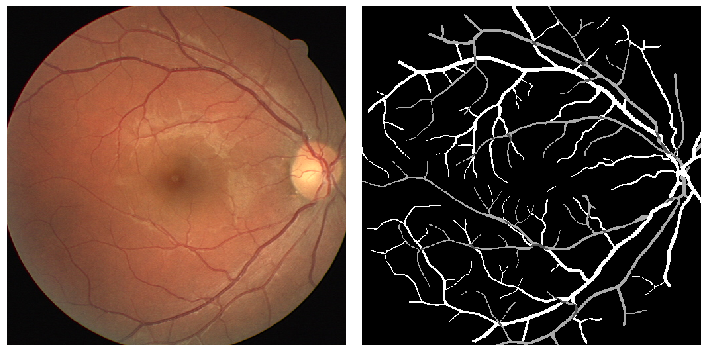

In [173]:
inputs = val_ds[0]
im, tg = inputs['img'], inputs['seg']
imshow_pair(im.numpy().transpose(1,2,0), tg[0])

In [174]:
from monai.data import CacheDataset, Dataset, PersistentDataset
import torch

In [175]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu:0")
device

device(type='cpu', index=0)

In [176]:
# directory = os.environ.get("MONAI_DATA_DIRECTORY")
# root_dir = tempfile.mkdtemp() if directory is None else directory
# print(root_dir)

In [177]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4,)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=1, num_workers=4)

In [150]:
n_classes=4

In [37]:
from monai.networks.nets import UNet
from monai.networks.layers import Norm

model = UNet(
        dimensions=2,
        in_channels=3,
        out_channels=n_classes,
        channels=(8, 16, 32),
        strides=(2, 2, 2),
        num_res_units=2,
        norm=Norm.BATCH,
    ).to(device)

In [178]:
x = next(iter(train_loader))
model(x['img']).shape

torch.Size([2, 4, 256, 256])

In [179]:
x = next(iter(val_loader))
model(x['img'].float()).shape

torch.Size([1, 4, 512, 512])

In [38]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

25169

In [230]:
optimizer = torch.optim.Adam(model.parameters(), 1e-2)
criterion = torch.nn.CrossEntropyLoss()

In [300]:
model.train()
for ep in range(50):
    for i_batch, batch_data in enumerate(train_loader):
        inputs, labels = (batch_data["img"].to(device), batch_data["seg"].to(device), )
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), (labels.squeeze()/(255/(n_classes-1))).long())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('Ep {}, L={:.3f}'.format(ep+1, loss.item()))
#     if i_batch == 3:
#         break

Ep 1, L=0.132
Ep 2, L=0.128
Ep 3, L=0.107
Ep 4, L=0.137
Ep 5, L=0.124
Ep 6, L=0.133
Ep 7, L=0.127
Ep 8, L=0.153
Ep 9, L=0.129
Ep 10, L=0.126
Ep 11, L=0.137
Ep 12, L=0.100
Ep 13, L=0.145
Ep 14, L=0.117
Ep 15, L=0.131
Ep 16, L=0.133
Ep 17, L=0.132
Ep 18, L=0.118
Ep 19, L=0.121
Ep 20, L=0.155
Ep 21, L=0.135
Ep 22, L=0.130
Ep 23, L=0.110
Ep 24, L=0.123
Ep 25, L=0.148
Ep 26, L=0.117
Ep 27, L=0.118
Ep 28, L=0.154
Ep 29, L=0.122
Ep 30, L=0.151
Ep 31, L=0.121
Ep 32, L=0.157
Ep 33, L=0.131
Ep 34, L=0.114
Ep 35, L=0.136
Ep 36, L=0.154
Ep 37, L=0.158
Ep 38, L=0.134
Ep 39, L=0.123
Ep 40, L=0.106
Ep 41, L=0.115
Ep 42, L=0.132
Ep 43, L=0.120
Ep 44, L=0.159
Ep 45, L=0.142
Ep 46, L=0.136
Ep 47, L=0.120
Ep 48, L=0.138
Ep 49, L=0.126
Ep 50, L=0.120


In [284]:
with torch.no_grad():
    for i_batch, batch_data in enumerate(val_loader):
        val_inputs, val_labels = batch_data["img"].to(device), batch_data["seg"].to(device)
        break

In [285]:
roi_size = (256,256)
sw_batch_size = 1

In [286]:
from monai.inferers import sliding_window_inference
from skimage.color import label2rgb

In [347]:
model.eval();
val_outputs = sliding_window_inference(val_inputs[0].unsqueeze(0).float(), 
                                       roi_size, sw_batch_size, 
                                       predictor=model, overlap=0.5, mode='gaussian')
pred = torch.argmax(val_outputs,dim=1)*(255/(n_classes-1))
prob = torch.nn.Softmax(dim=1)(val_outputs).detach().numpy()

In [348]:
prob = np.stack([1-prob[0,0,:,:],prob[0,2,:,:],prob[0,3,:,:]], axis=2)

In [349]:
torch.unique(pred[0])

tensor([  0.,  85., 170., 255.])

In [350]:
full_rgb_pred = label2rgb(pred[0].numpy().astype(int), colors=['black', 'green', 'red', 'blue'])

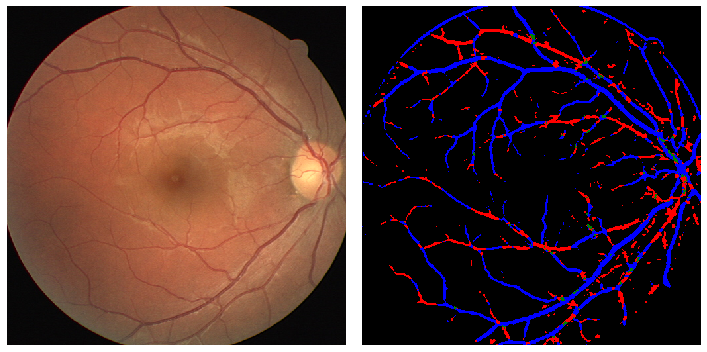

In [351]:
imshow_pair(val_inputs[0].numpy().transpose(1,2,0), full_rgb_pred)

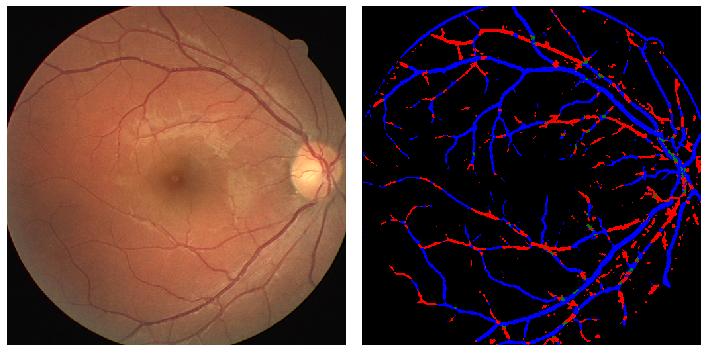

In [336]:
imshow_pair(val_inputs[0].numpy().transpose(1,2,0), full_rgb_pred)

In [41]:
inputs[0].shape, labels[0].shape

(torch.Size([3, 256, 256]), torch.Size([1, 256, 256]))

In [42]:
outputs = model(inputs)

In [43]:
outputs.shape, labels.shape

(torch.Size([2, 4, 256, 256]), torch.Size([2, 1, 256, 256]))

In [57]:
255/3

85.0

In [59]:
torch.unique(labels), torch.unique(labels/(255/(n_classes-1)))

(tensor([  0.,  85., 170., 255.]), tensor([0., 1., 2., 3.]))

In [63]:
loss = criterion(outputs.squeeze(), (labels.squeeze()/(255/(n_classes-1))).long())
loss

tensor(1.6036, grad_fn=<NllLoss2DBackward>)

In [66]:
optimizer.zero_grad()
loss.backward()
optimizer.step()